<a href="https://colab.research.google.com/github/Z-TRI/My-projects/blob/main/VQA_V2_CNN%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.makedirs('/content/data_cache/train', exist_ok=True)
os.makedirs('/content/data_cache/val', exist_ok=True)
!cp -r "/content/drive/MyDrive/Colab Notebooks/Thesis/data/train/"* "/content/data_cache/train/"
!cp -r "/content/drive/MyDrive/Colab Notebooks/Thesis/data/val/"* "/content/data_cache/val/"

In [ ]:
%reset -f

In [ ]:
import os
import re
import json
base_dir = '/content/data_cache'

## ID image train

In [ ]:
# 1. Xác định đường dẫn đến thư mục cha chứa các ảnh huấn luyện COCO 2014 đã chia
base_train_images_path = os.path.join(base_dir, 'train')
train_subdirs = [
    os.path.join(base_train_images_path, 'train2014_1'),
    os.path.join(base_train_images_path, 'train2014_2'),
    os.path.join(base_train_images_path, 'train2014_3'),
    os.path.join(base_train_images_path, 'train2014_4'),
    os.path.join(base_train_images_path, 'train2014_5')
]

In [ ]:
# 1. Xác định đường dẫn đến tệp câu hỏi huấn luyện VQA v2.0
vqa_train_questions_path = os.path.join(base_dir, 'train', 'v2_OpenEnded_mscoco_train2014_questions.json')
# 4. Lưu trữ các image_id duy nhất vào một tập hợp (set)
vqa_train_image_ids = set()
# 2. Tải tệp JSON
if not os.path.exists(vqa_train_questions_path):
    print(f"Error: VQA training questions file not found at '{vqa_train_questions_path}'")
else:
    with open(vqa_train_questions_path, 'r') as f:
        vqa_train_data = json.load(f)

    # 3. Duyệt qua danh sách câu hỏi và trích xuất image_id cho mỗi câu hỏi.
    for question_entry in vqa_train_data['questions']:
        vqa_train_image_ids.add(str(question_entry['image_id'])) # Ensure image_id is treated as string for consistency with COCO IDs

    print(f"Extracted {len(vqa_train_image_ids)} unique VQA training question image IDs.")
    # print(f"First 5 IDs: {list(vqa_train_image_ids)[:5]}") # Optional: to check a few IDs

Extracted 82783 unique VQA training question image IDs.


## Validation ID images

In [ ]:
# 1. Xác định đường dẫn đến thư mục cha chứa các ảnh kiểm định COCO 2014 đã chia
base_val_images_path = os.path.join(base_dir, 'val')
val_subdirs = [
    os.path.join(base_val_images_path, 'val2014_1'),
    os.path.join(base_val_images_path, 'val2014_2'),
    os.path.join(base_val_images_path, 'val2014_3')
]

In [ ]:
# 1. Xác định đường dẫn đến tệp câu hỏi kiểm định VQA v2.0
vqa_val_questions_path = os.path.join(base_dir, 'val', 'v2_OpenEnded_mscoco_val2014_questions.json')

# 4. Lưu trữ các image_id duy nhất vào một tập hợp (set)
vqa_val_image_ids = set()

# 2. Tải tệp JSON
if not os.path.exists(vqa_val_questions_path):
    print(f"Error: VQA validation questions file not found at '{vqa_val_questions_path}'")
else:
    with open(vqa_val_questions_path, 'r') as f:
        vqa_val_data = json.load(f)

    # 3. Duyệt qua danh sách câu hỏi và trích xuất image_id cho mỗi câu hỏi.
    for question_entry in vqa_val_data['questions']:
        vqa_val_image_ids.add(str(question_entry['image_id'])) # Ensure image_id is treated as string for consistency with COCO IDs

    print(f"Extracted {len(vqa_val_image_ids)} unique VQA validation question image IDs.")
    # print(f"First 5 IDs: {list(vqa_val_image_ids)[:5]}") # Optional: to check a few IDs

Extracted 40504 unique VQA validation question image IDs.


## check format annotation

In [ ]:
# Đường dẫn đến tệp annotations huấn luyện VQA v2.0
vqa_train_annotations_path = os.path.join(base_dir, 'train', 'v2_mscoco_train2014_annotations.json')

print(f"Kiểm tra cấu trúc tệp annotation từ: {vqa_train_annotations_path}")

if not os.path.exists(vqa_train_annotations_path):
    print(f"Lỗi: Tệp annotation không tìm thấy tại '{vqa_train_annotations_path}'")
else:
    with open(vqa_train_annotations_path, 'r') as f:
        annotations_data = json.load(f)

    print("\nCác khóa cấp cao nhất trong tệp annotation:")
    print(annotations_data.keys())

    if 'annotations' in annotations_data and isinstance(annotations_data['annotations'], list):
        print(f"\nTổng số annotations: {len(annotations_data['annotations'])}")
        if annotations_data['annotations']:
            print("\nCấu trúc của mục annotation đầu tiên:")
            # Pretty print the first entry for better readability
            print(json.dumps(annotations_data['annotations'][900], indent=2))
            print('danh sách các key của 1 entry:\n')
            print(annotations_data['annotations'][900].keys())
        else:
            print("Danh sách 'annotations' trống.")
    else:
        print("\nKhông tìm thấy khóa 'annotations' hoặc nó không phải là một danh sách.")


Kiểm tra cấu trúc tệp annotation từ: /content/data_cache/train/v2_mscoco_train2014_annotations.json

Các khóa cấp cao nhất trong tệp annotation:
dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])

Tổng số annotations: 443757

Cấu trúc của mục annotation đầu tiên:
{
  "answer_type": "yes/no",
  "multiple_choice_answer": "no",
  "answers": [
    {
      "answer": "no",
      "answer_confidence": "yes",
      "answer_id": 1
    },
    {
      "answer": "no",
      "answer_confidence": "yes",
      "answer_id": 2
    },
    {
      "answer": "no",
      "answer_confidence": "yes",
      "answer_id": 3
    },
    {
      "answer": "no",
      "answer_confidence": "yes",
      "answer_id": 4
    },
    {
      "answer": "no",
      "answer_confidence": "yes",
      "answer_id": 5
    },
    {
      "answer": "no",
      "answer_confidence": "yes",
      "answer_id": 6
    },
    {
      "answer": "no",
      "answer_confidence": "yes",
      "answer_id": 7
    },
    

## Check format question

In [ ]:
# Đường dẫn đến tệp câu hỏi huấn luyện VQA v2.0
vqa_train_questions_path = os.path.join(base_dir, 'train', 'v2_OpenEnded_mscoco_train2014_questions.json')

print(f"Kiểm tra cấu trúc tệp câu hỏi từ: {vqa_train_questions_path}")

if not os.path.exists(vqa_train_questions_path):
    print(f"Lỗi: Tệp câu hỏi không tìm thấy tại '{vqa_train_questions_path}'")
else:
    with open(vqa_train_questions_path, 'r') as f:
        questions_data = json.load(f)

    print("\nCác khóa cấp cao nhất trong tệp câu hỏi:")
    print(questions_data.keys())

    if 'questions' in questions_data and isinstance(questions_data['questions'], list):
        print(f"\nTổng số câu hỏi: {len(questions_data['questions'])}")
        if questions_data['questions']:
            print("\nCấu trúc của mục câu hỏi đầu tiên:")
            # Pretty print the first entry for better readability
            print(json.dumps(questions_data['questions'][0], indent=2))
            print('\ndanh sách các key của 1 entry:\n')
            print(questions_data['questions'][0].keys())
        else:
            print("Danh sách 'questions' trống.")
    else:
        print("\nKhông tìm thấy khóa 'questions' hoặc nó không phải là một danh sách.")

Kiểm tra cấu trúc tệp câu hỏi từ: /content/data_cache/train/v2_OpenEnded_mscoco_train2014_questions.json

Các khóa cấp cao nhất trong tệp câu hỏi:
dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])

Tổng số câu hỏi: 443757

Cấu trúc của mục câu hỏi đầu tiên:
{
  "image_id": 458752,
  "question": "What is this photo taken looking through?",
  "question_id": 458752000
}

danh sách các key của 1 entry:

dict_keys(['image_id', 'question', 'question_id'])


# **Reduce dataset for POC**

In [ ]:
import pandas as pd
from collections import Counter

# Function to create soft target labels from the 'answers' list
def create_soft_target(answers_list):
    answer_counts = Counter([ans['answer'] for ans in answers_list])
    # VQA evaluation metric uses min(1, count/3) for soft targets
    soft_target = {answer: min(1.0, count / 3.0) for answer, count in answer_counts.items()}
    return soft_target

# Convert annotations_data['annotations'] to a pandas DataFrame
# Select necessary columns, including 'answers' to compute soft_target_label
df_annotations = pd.DataFrame(annotations_data['annotations'])[['image_id', 'question_id', 'question_type', 'answer_type', 'answers']]

# Apply the function to create the 'soft_target_label' column
df_annotations['soft_target_label'] = df_annotations['answers'].apply(create_soft_target)

# Ensure image_id is consistent (integer in annotations, string in VQA questions, best to keep consistent)
df_annotations['image_id'] = df_annotations['image_id'].astype(str)

print(f"Created df_annotations with shape: {df_annotations.shape}")
print("First 5 rows of df_annotations:")
print(df_annotations.head())
print("\nExample of a soft_target_label for the first entry:")
print(df_annotations['soft_target_label'].iloc[0])

Created df_annotations with shape: (443757, 6)
First 5 rows of df_annotations:
  image_id  question_id      question_type answer_type  \
0   458752    458752000       what is this       other   
1   458752    458752001               what       other   
2   458752    458752002  what color is the       other   
3   458752    458752003            is this      yes/no   
4   262146    262146000  what color is the       other   

                                             answers  \
0  [{'answer': 'net', 'answer_confidence': 'maybe...   
1  [{'answer': 'pitcher', 'answer_confidence': 'y...   
2  [{'answer': 'orange', 'answer_confidence': 'ye...   
3  [{'answer': 'yes', 'answer_confidence': 'yes',...   
4  [{'answer': 'white', 'answer_confidence': 'yes...   

                                   soft_target_label  
0  {'net': 1.0, 'netting': 0.3333333333333333, 'm...  
1    {'pitcher': 1.0, 'catcher': 0.3333333333333333}  
2                                    {'orange': 1.0}  
3             {

In [ ]:
import pandas as pd
import numpy as np

# 1. Tính tần suất và trọng số nghịch đảo cho từng question_type
# (Càng ít xuất hiện, trọng số càng cao)
q_counts = df_annotations['question_type'].value_counts()
q_weights = 1.0 / q_counts

# Map trọng số này vào dataframe gốc
df_annotations['q_weight'] = df_annotations['question_type'].map(q_weights)

# 2. Tính điểm số cho từng ảnh (Image Score)
# Group theo image_id và cộng tổng trọng số các câu hỏi của ảnh đó
image_scores = df_annotations.groupby('image_id')['q_weight'].sum()

# 3. Lấy mẫu 20,000 ảnh dựa trên trọng số (Weighted Sampling)
# weights=image_scores đảm bảo ảnh có câu hỏi hiếm dễ được chọn hơn
sampled_image_ids = image_scores.sample(
    n=20000,
    weights=image_scores,
    random_state=42
).index

# 4. Tạo dataset POC
# Chỉ giữ lại các dòng có image_id nằm trong danh sách đã chọn
df_poc = df_annotations[df_annotations['image_id'].isin(sampled_image_ids)].copy()

# --- Kiểm tra kết quả ---
original_unique_q = df_annotations['question_type'].nunique()
poc_unique_q = df_poc['question_type'].nunique()

print(f"Số lượng ảnh gốc: {df_annotations['image_id'].nunique()}")
print(f"Số lượng ảnh POC: {df_poc['image_id'].nunique()}")
print(f"Số lượng câu hỏi trong POC: {len(df_poc)}")
print(f"Số loại câu hỏi (Classes) được giữ lại: {poc_unique_q}/{original_unique_q}")

Số lượng ảnh gốc: 82783
Số lượng ảnh POC: 20000
Số lượng câu hỏi trong POC: 158574
Số loại câu hỏi (Classes) được giữ lại: 65/65


In [ ]:
df_poc = df_poc.reset_index(drop=True)
df_poc

,image_id,question_id,question_type,answer_type,answers,soft_target_label,q_weight
0,524291,524291000,what is in the,other,"[{'answer': 'frisbee', 'answer_confidence': 'y...","{'frisbee': 1.0, 'white frisbee': 0.3333333333...",0.000251
1,524291,524291001,is the,yes/no,"[{'answer': 'yes', 'answer_confidence': 'yes',...",{'yes': 1.0},0.000029
2,524291,524291002,is the,other,"[{'answer': 'frisbee', 'answer_confidence': 'y...",{'frisbee': 1.0},0.000029
3,393224,393224000,is the man,yes/no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",{'no': 1.0},0.000201
4,393224,393224001,what is the,other,"[{'answer': 'waiting', 'answer_confidence': 'm...","{'waiting': 0.3333333333333333, 'standing': 0....",0.000041
...,...,...,...,...,...,...,...
158569,477475,477475025,what color is the,other,"[{'answer': 'black', 'answer_confidence': 'yes...","{'black': 1.0, 'black pink': 0.333333333333333...",0.000036
158570,262136,262136000,none of the above,yes/no,"[{'answer': 'yes', 'answer_confidence': 'yes',...",{'yes': 1.0},0.000059
158571,262136,262136001,how,number,"[{'answer': 'medium heaviness', 'answer_confid...","{'medium heaviness': 0.3333333333333333, '170 ...",0.000211
158572,262136,262136002,is this a,yes/no,"[{'answer': 'no', 'answer_confidence': 'yes', ...","{'no': 1.0, 'yes': 0.3333333333333333}",0.000062


In [ ]:
import glob
from tqdm import tqdm

def create_image_path_map(subdirs):
    """
    Tạo dictionary mapping: image_id -> full_path
    """
    image_map = {}
    print("Đang index đường dẫn ảnh...")
    for folder in subdirs:
        # Giả sử ảnh có định dạng COCO_train2014_000000xxxxxx.jpg
        # Hoặc chỉ đơn giản là tìm tất cả file jpg
        files = glob.glob(os.path.join(folder, "*.jpg"))
        for f in tqdm(files, desc=f"Scanning {os.path.basename(folder)}"):
            # Lấy image_id từ tên file.
            # Format COCO: COCO_train2014_000000524291.jpg -> id là 524291
            filename = os.path.basename(f)
            # Trích xuất số id từ chuỗi (loại bỏ số 0 ở đầu)
            try:
                # Cách lấy ID an toàn dựa trên format COCO
                id_str = filename.split('_')[-1].split('.')[0]
                image_id = str(int(id_str)) # Chuyển về int rồi về str để khớp với df
                image_map[image_id] = f
            except:
                continue
    return image_map

# Tạo map cho train (từ 5 folder) và val (từ 3 folder)
train_img_map = create_image_path_map(train_subdirs)
val_img_map = create_image_path_map(val_subdirs)

print(f"Total train images indexed: {len(train_img_map)}")
print(f"Total val images indexed: {len(val_img_map)}")

Đang index đường dẫn ảnh...


Scanning train2014_5: 100%|██████████| 16783/16783 [00:00<00:00, 703451.69it/s]


Đang index đường dẫn ảnh...


Scanning val2014_3: 100%|██████████| 13504/13504 [00:00<00:00, 780367.88it/s]

Total train images indexed: 82783
Total val images indexed: 40504


## crreate folder POC images for next time using  

In [ ]:
import os
import shutil
from tqdm import tqdm

# 1. Định nghĩa thư mục đích
dest_dir = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/train/train_poc'

# 2. Tạo thư mục đích nếu chưa tồn tại
os.makedirs(dest_dir, exist_ok=True)
print(f"Thư mục đích '{dest_dir}' đã được đảm bảo tồn tại.")

# 3. Lấy danh sách các image_id từ df_poc
# df_poc['image_id'] đang ở dạng string
poc_image_ids = df_poc['image_id'].unique().tolist()

print(f"Đang copy {len(poc_image_ids)} ảnh từ dataset POC...")

# 4. Copy các file ảnh
# train_img_map là dictionary: image_id (str) -> full_path
for img_id in tqdm(poc_image_ids, desc="Copying images"):
    source_path = train_img_map.get(img_id)
    if source_path and os.path.exists(source_path):
        dest_path = os.path.join(dest_dir, os.path.basename(source_path))
        try:
            shutil.copy(source_path, dest_path)
        except Exception as e:
            print(f"Lỗi khi copy ảnh {img_id} từ {source_path}: {e}")
    # else:
    #     print(f"Cảnh báo: Không tìm thấy đường dẫn cho image_id {img_id}") # Bỏ comment nếu muốn debug ảnh thiếu

print(f"Đã hoàn tất việc copy ảnh vào '{dest_dir}'.")

## Begin pipeline training

In [ ]:
import torch
import re
from collections import Counter

# --- 1. MERGE CÂU HỎI VÀO DATAFRAME ---
# df_poc hiện tại thiếu nội dung câu hỏi text, cần merge từ questions_data
# Tạo dictionary ánh xạ: question_id -> question string
print("Đang merge nội dung câu hỏi...")
qid_to_text = {q['question_id']: q['question'] for q in questions_data['questions']}

# Map vào df_poc
df_poc['question_text'] = df_poc['question_id'].map(qid_to_text)

# Kiểm tra xem có dòng nào bị thiếu text không
if df_poc['question_text'].isnull().any():
    print("Cảnh báo: Có câu hỏi không tìm thấy nội dung text. Đang drop...")
    df_poc = df_poc.dropna(subset=['question_text'])

print(f"Sample question: {df_poc.iloc[0]['question_text']}")


# --- 2. XÂY DỰNG ANSWER VOCABULARY (LABEL SPACE) ---
print("\nĐang xây dựng Answer Vocabulary...")
all_answers = []
# df_annotations chứa full dữ liệu, nên dùng nó để build vocab cho tổng quát
# FIX: Correctly iterate through annotation entries and their 'answers' list
for annotation_entry in annotations_data['annotations']:
    if 'answers' in annotation_entry and isinstance(annotation_entry['answers'], list):
        for answer_dict in annotation_entry['answers']:
            if 'answer' in answer_dict:
                all_answers.append(answer_dict['answer'])

answer_counts = Counter(all_answers)
# Lấy 4000 câu trả lời phổ biến nhất cho POC (based on kernel state)
TOP_K_ANSWERS = 4000
sorted_answers = answer_counts.most_common(TOP_K_ANSWERS)

# Tạo mapping: Answer String -> Index
ans_to_idx = {ans: i for i, (ans, count) in enumerate(sorted_answers)}
print(f"Số lượng classes (answers): {len(ans_to_idx)}")
print(f"Top 5 answers: {sorted_answers[:5]}")


# --- 3. XÂY DỰNG QUESTION VOCABULARY (THAY THẾ TORCHTEXT) ---
print("\nĐang xây dựng Question Vocabulary...")

class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
        self.idx = 4 # Bắt đầu index tiếp theo

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        # Tokenizer đơn giản: chuyển thường + tách dấu câu cơ bản bằng Regex
        text = text.lower()
        # Tách các ký tự đặc biệt ra khỏi từ
        text = re.sub(r"([.,!?])", r" \1 ", text)
        # Loại bỏ ký tự lạ
        text = re.sub(r"[^a-zA-Z0-9.,!?]+", " ", text)
        return text.split()

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        # First pass to count frequencies
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1

        # Second pass to add to vocab based on frequency threshold
        idx = self.idx # Reset idx for adding new words
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
        self.idx = idx

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# Khởi tạo và build vocab
vocab = Vocabulary(freq_threshold=1)
# Chỉ build vocab trên tập câu hỏi huấn luyện (để tránh data leakage)
vocab.build_vocabulary(df_poc['question_text'].tolist())

print(f"Vocab size: {len(vocab)}")
print(f"Testing tokenizer: 'What is this?' -> {vocab.numericalize('What is this?')}")

Đang merge nội dung câu hỏi...
Sample question: What is in the person's hand?

Đang xây dựng Answer Vocabulary...
Số lượng classes (answers): 4000
Top 5 answers: [('no', 834552), ('yes', 825565), ('2', 122798), ('1', 121020), ('white', 80726)]

Đang xây dựng Question Vocabulary...
Vocab size: 9998
Testing tokenizer: 'What is this?' -> [4, 5, 35, 11]


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch

class VQADataset(Dataset):
    def __init__(self, df, img_map, vocab, ans_to_idx, transform=None, max_len=20):
        self.df = df.reset_index(drop=True)
        self.img_map = img_map
        self.vocab = vocab
        self.ans_to_idx = ans_to_idx
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(row['image_id'])

        # --- 1. Xử lý Ảnh ---
        img_path = self.img_map.get(img_id)
        image = torch.zeros(3, 224, 224) # Ảnh đen mặc định nếu lỗi

        if img_path:
            try:
                img = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(img)
            except Exception as e:
                # print(f"Error loading image {img_id}: {e}")
                pass

        # --- 2. Xử lý Câu hỏi (Padding/Truncating) ---
        q_text = row['question_text']
        q_indices = self.vocab.numericalize(q_text)

        # Cắt hoặc đệm thêm (Padding)
        if len(q_indices) > self.max_len:
            q_indices = q_indices[:self.max_len]
        else:
            pad_len = self.max_len - len(q_indices)
            q_indices += [self.vocab.stoi["<PAD>"]] * pad_len

        q_tensor = torch.tensor(q_indices, dtype=torch.long)

        # --- 3. Xử lý Target (Soft Labels) ---
        # Tạo vector 0 với kích thước bằng số lượng câu trả lời (4000)
        target = torch.zeros(len(self.ans_to_idx))
        soft_labels = row['soft_target_label']

        # Điền điểm số vào các vị trí index tương ứng
        if isinstance(soft_labels, dict):
            for ans, score in soft_labels.items():
                if ans in self.ans_to_idx:
                    idx = self.ans_to_idx[ans]
                    target[idx] = score

        return image, q_tensor, target

# Transforms chuẩn cho ResNet
# >>> CHÚ Ý: Nếu thay đổi model ảnh, phần transform này có thể cần thay đổi <<<
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# --- 1. Load Annotations & Questions cho Validation ---
print("Đang chuẩn bị dữ liệu Validation...")

# Load Questions Val
with open(vqa_val_questions_path, 'r') as f:
    val_questions_data = json.load(f)
qid_to_text_val = {q['question_id']: q['question'] for q in val_questions_data['questions']}

# Load Annotations Val
vqa_val_annotations_path = os.path.join(base_dir, 'val', 'v2_mscoco_val2014_annotations.json')
with open(vqa_val_annotations_path, 'r') as f:
    val_annotations_data = json.load(f)

# --- 2. Tạo DataFrame Validation ---
df_val = pd.DataFrame(val_annotations_data['annotations'])[['image_id', 'question_id', 'question_type', 'answer_type', 'answers']]

# Tạo soft target cho Val (dùng hàm create_soft_target bạn đã định nghĩa ở cell cũ)
df_val['soft_target_label'] = df_val['answers'].apply(create_soft_target)

# Merge câu hỏi text
df_val['question_text'] = df_val['question_id'].map(qid_to_text_val)
df_val['image_id'] = df_val['image_id'].astype(str)

# Lọc bỏ câu hỏi thiếu text (nếu có)
df_val = df_val.dropna(subset=['question_text'])

# --- 3. Reduce Validation Dataset for POC ---
print("\nĐang giảm kích thước dataset validation cho POC...")

# 1. Tính tần suất và trọng số nghịch đảo cho từng question_type trong df_val
val_q_counts = df_val['question_type'].value_counts()
val_q_weights = 1.0 / val_q_counts

# Map trọng số này vào dataframe gốc của val
df_val['q_weight'] = df_val['question_type'].map(val_q_weights)

# 2. Tính điểm số cho từng ảnh (Image Score) trong val
val_image_scores = df_val.groupby('image_id')['q_weight'].sum()

# 3. Lấy mẫu 5,000 ảnh dựa trên trọng số (Weighted Sampling)
sampled_val_image_ids = val_image_scores.sample(
    n=5000, # Giảm xuống 5000 ảnh cho validation POC
    weights=val_image_scores,
    random_state=42
).index

# 4. Tạo dataset POC cho validation
df_val_poc = df_val[df_val['image_id'].isin(sampled_val_image_ids)].copy()

# Reset index cho df_val_poc
df_val_poc = df_val_poc.reset_index(drop=True)

# --- Kiểm tra kết quả validation POC ---
original_val_unique_q = df_val['question_type'].nunique()
poc_val_unique_q = df_val_poc['question_type'].nunique()

print(f"Số lượng ảnh gốc trong Val: {df_val['image_id'].nunique()}")
print(f"Số lượng ảnh POC trong Val: {df_val_poc['image_id'].nunique()}")
print(f"Số lượng câu hỏi trong Val POC: {len(df_val_poc)}")
print(f"Số loại câu hỏi (Classes) được giữ lại trong Val POC: {poc_val_unique_q}/{original_val_unique_q}")

Đang chuẩn bị dữ liệu Validation...

Đang giảm kích thước dataset validation cho POC...
Số lượng ảnh gốc trong Val: 40504
Số lượng ảnh POC trong Val: 5000
Số lượng câu hỏi trong Val POC: 42448
Số loại câu hỏi (Classes) được giữ lại trong Val POC: 65/65


In [ ]:
print(f"Training Data Shape: {df_poc.shape}")
print(f"Validation Data Shape: {df_val_poc.shape}")

# --- 3. Tạo DataLoader ---
# Train Loader
train_dataset = VQADataset(df_poc, train_img_map, vocab, ans_to_idx, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Val Loader (Không shuffle)
val_dataset = VQADataset(df_val_poc, val_img_map, vocab, ans_to_idx, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

Training Data Shape: (158574, 8)
Validation Data Shape: (42448, 8)


Đang lấy một batch từ train_loader để kiểm tra...
Batch size: 128
Image batch shape: torch.Size([128, 3, 224, 224])
Question batch shape: torch.Size([128, 20])
Target batch shape: torch.Size([128, 4000])

--- Sample 1 --- 
Question: what airline do the planes belong to ?
Top 5 Answers and their Soft Scores:
  - private: 1.0000
  - american: 0.6667
  - none: 0.3333
  - united: 0.3333
  - southwest: 0.3333


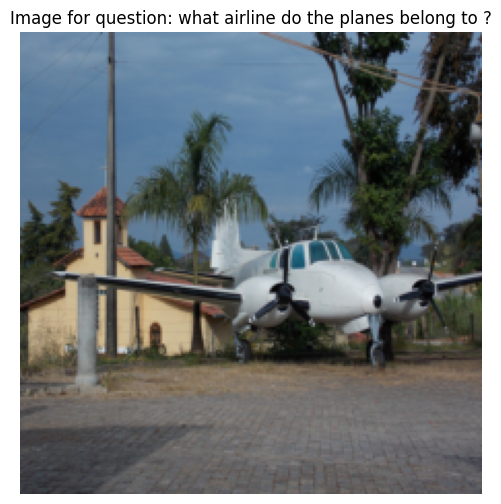

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Get a batch from the train_loader
print("Đang lấy một batch từ train_loader để kiểm tra...")
images, questions, targets = next(iter(train_loader))

print(f"Batch size: {images.shape[0]}")
print(f"Image batch shape: {images.shape}") # Expected: [batch_size, 3, 224, 224]
print(f"Question batch shape: {questions.shape}") # Expected: [batch_size, max_len]
print(f"Target batch shape: {targets.shape}") # Expected: [batch_size, num_classes]

# Lấy một sample đầu tiên trong batch
sample_image = images[0]
sample_question = questions[0]
sample_target = targets[0]

print("\n--- Sample 1 --- ")

# Giải mã câu hỏi
# Chuyển numericalized question về list các từ
question_words = [vocab.itos[idx.item()] for idx in sample_question if vocab.itos[idx.item()] != '<PAD>']
question_text = ' '.join(question_words)
print(f"Question: {question_text}")

# Giải mã target (soft labels)
# Sắp xếp các câu trả lời theo điểm số giảm dần
ans_scores = {idx: score.item() for idx, score in enumerate(sample_target) if score.item() > 0}

# Đảo ngược ans_to_idx để map index về answer string
idx_to_ans = {idx: ans for ans, idx in ans_to_idx.items()}

sorted_ans_scores = sorted(ans_scores.items(), key=lambda item: item[1], reverse=True)

print("Top 5 Answers and their Soft Scores:")
for idx, score in sorted_ans_scores[:5]:
    print(f"  - {idx_to_ans.get(idx, 'UNKNOWN_ANSWER')}: {score:.4f}")

# Hiển thị ảnh
# Inverse normalize the image for display
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Convert tensor to numpy array for display
img_for_display = inv_normalize(sample_image).permute(1, 2, 0).cpu().numpy()
img_for_display = np.clip(img_for_display, 0, 1) # Clip values to [0,1]

plt.figure(figsize=(6, 6))
plt.imshow(img_for_display)
plt.title(f"Image for question: {question_text}")
plt.axis('off')
plt.show()


In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch # Added this import

class SimpleVQA(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(SimpleVQA, self).__init__()

        # --- Image Encoder (MobileNetV2) ---
        # Dùng MobileNetV2 pre-trained trên ImageNet
        # Sửa lỗi: Thay vì weights=models.MobileNetV2_Weights.IMAGENET1K_V1, dùng pretrained=True cho tương thích ngược
        mobilenet = models.mobilenet_v2(pretrained=True)

        # Bỏ lớp classifier cuối cùng, lấy features
        # MobileNetV2 output feature map trước classifier là 1280
        # Kích thước này cần được xác định dựa trên model bạn chọn.
        self.image_features_extractor = nn.Sequential(*list(mobilenet.children())[:-1])
        # Lớp `mobilenet.classifier` là `Sequential(Linear(1280, 1000))`.
        # Ta cần lấy output của `mobilenet.features` chính là 1280.
        self.img_fc = nn.Linear(1280, hidden_dim) # Thay đổi từ 512 sang 1280
        self.dropout_img = nn.Dropout(0.5)

        # --- Question Encoder (LSTM) ---
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Batch_first=True: input shape (Batch, Seq_Len, Dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.text_fc = nn.Linear(hidden_dim, hidden_dim)
        self.dropout_text = nn.Dropout(0.5)

        # --- Classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim * 2, num_classes)
        )

    def forward(self, img, question):
        # 1. Image Branch
        # Img: [Batch, 3, 224, 224] -> MobileNetV2 features -> [Batch, 1280, 1, 1]
        img_feat = self.image_features_extractor(img) # Đổi tên biến cho rõ ràng
        img_feat = img_feat.mean([2, 3]) # Global Average Pooling cho output của MobileNetV2 features
        img_emb = self.img_fc(img_feat)
        img_emb = torch.tanh(img_emb)
        img_emb = self.dropout_img(img_emb)

        # 2. Text Branch
        # Question: [Batch, 30]
        txt_emb = self.embedding(question) # [Batch, 30, embed_dim]
        # LSTM output: output, (h_n, c_n)
        _, (hidden, cell) = self.lstm(txt_emb)
        # Lấy hidden state cuối cùng: [1, Batch, hidden_dim] -> [Batch, hidden_dim]
        txt_emb = self.text_fc(hidden[-1])
        txt_emb = torch.tanh(txt_emb)
        txt_emb = self.dropout_text(txt_emb)

        # 3. Fusion (Element-wise Multiplication)
        fused = img_emb * txt_emb

        # 4. Classification
        logits = self.classifier(fused)
        return logits

# Khởi tạo Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

model = SimpleVQA(
    vocab_size=len(vocab),
    embed_dim=512, # Đã tăng kích thước embed_dim lên 512
    hidden_dim=1024,
    num_classes=len(ans_to_idx)
).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 202MB/s]


In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Dừng training sớm nếu validation loss không cải thiện sau một số epoch nhất định."""
    def __init__(self, patience=2, verbose=False, path='/content/drive/MyDrive/Colab Notebooks/Thesis/save_model/MobileNetV2_LSTM_1.pth'):
        """
        Args:
            patience (int): Số epoch chờ đợi sau khi loss không giảm.
            verbose (bool): Nếu True, in ra thông báo mỗi khi lưu model mới.
            path (str): Đường dẫn lưu file checkpoint model.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf # Changed np.Inf to np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss # Chúng ta muốn loss càng nhỏ càng tốt, nên đổi dấu để so sánh

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score:
            # Loss không giảm (hoặc tăng)
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Loss giảm -> Reset counter và lưu model mới
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Lưu model khi validation loss giảm.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
import torch.optim as optim
import time
import torch
import torch.nn as nn

# --- 1. Cấu hình Training ---
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/save_model/MobileNetV2_LSTM.pth'
learning_rate = 0.001
num_epochs = 20

# Loss Function: QUAN TRỌNG cho Multi-label Soft Targets
# Thay đổi: reduction='sum' để tính tổng lỗi, sau đó chia cho batch_size.
# Lý do: Default 'mean' sẽ chia cho (batch_size * num_classes), làm loss cực nhỏ (ví dụ 0.002)
# vì 99% classes là 0. Điều này làm khó quan sát biến động và gradient có thể quá nhỏ.
criterion = nn.BCEWithLogitsLoss(reduction='sum')

# Optimizer
# Chỉ update params có requires_grad=True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Scheduler: Giảm LR khi loss không giảm nữa
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# --- 2. Chiến lược Freezing (Đóng băng) ---
# Để tránh phá hỏng weights của ResNet pre-trained, ta đóng băng nó trong các epoch đầu
print("Freezing MobileNetV2 backbone...") # Changed to reflect MobileNetV2
for param in model.image_features_extractor.parameters(): # Changed to reflect MobileNetV2 structure
    param.requires_grad = False

# Cập nhật lại optimizer (đề phòng)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


# --- 3. Hàm tính độ chính xác VQA (Soft Accuracy) ---
def compute_vqa_accuracy(output, target):
    # Output shape: [batch, num_classes]
    # Target shape: [batch, num_classes] (Soft targets)

    # Lấy câu trả lời có điểm cao nhất từ model
    _, pred_indices = torch.max(output, 1) # [batch]

    # Lấy điểm số soft-target tương ứng với index mà model dự đoán
    # gather(dim, index_tensor)
    pred_scores = torch.gather(target, 1, pred_indices.view(-1, 1))

    return pred_scores.mean().item()


# --- 4. Training Loop ---
early_stopping = EarlyStopping(patience=3, verbose=True, path=model_save_path)
print("Start Training (Optimized w/ Scaled Loss)...")

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    train_acc = 0

    # (Optional) Unfreeze sau epoch 5
    # if epoch == 5:
    #     print("Unfreezing MobileNetV2 backbone...")
    #     for param in model.image_features_extractor.parameters():
    #         param.requires_grad = True
    #     optimizer.add_param_group({'params': model.image_features_extractor.parameters(), 'lr': learning_rate * 0.1})

    for i, (imgs, questions, targets) in enumerate(train_loader):
        imgs, questions, targets = imgs.to(device), questions.to(device), targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(imgs, questions)

        # Loss Calculation (Scaled)
        # Tính tổng loss rồi chia cho batch size -> Loss trung bình trên mỗi Sample
        # Giá trị sẽ rơi vào khoảng 5.0 - 20.0, dễ quan sát hơn.
        loss = criterion(outputs, targets) / imgs.size(0)

        # Backward
        loss.backward()

        # Gradient Clipping: Chống bùng nổ gradient (thường gặp với LSTM)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        # Optimize
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_vqa_accuracy(outputs, targets)

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for imgs, questions, targets in val_loader:
            imgs, questions, targets = imgs.to(device), questions.to(device), targets.to(device)
            outputs = model(imgs, questions)
            # Loss validation cũng phải tính theo cách tương tự
            loss = criterion(outputs, targets) / imgs.size(0)
            val_loss += loss.item()
            val_acc += compute_vqa_accuracy(outputs, targets)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # Update Scheduler
    scheduler.step(avg_val_loss)

    epoch_time = time.time() - start_time
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Completed in {epoch_time:.0f}s")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    # Early Stopping check
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training Finished.")

Freezing MobileNetV2 backbone...
Start Training (Optimized w/ Scaled Loss)...
Epoch [1/20], Step [0/1239], Loss: 2772.4656
Epoch [1/20], Step [50/1239], Loss: 10.7631
Epoch [1/20], Step [100/1239], Loss: 10.8680
Epoch [1/20], Step [150/1239], Loss: 9.7522
Epoch [1/20], Step [200/1239], Loss: 10.7898
Epoch [1/20], Step [250/1239], Loss: 10.8837
Epoch [1/20], Step [300/1239], Loss: 9.8210
Epoch [1/20], Step [350/1239], Loss: 9.6556
Epoch [1/20], Step [400/1239], Loss: 8.5307
Epoch [1/20], Step [450/1239], Loss: 11.1701
Epoch [1/20], Step [500/1239], Loss: 9.8664
Epoch [1/20], Step [550/1239], Loss: 10.9997
Epoch [1/20], Step [600/1239], Loss: 10.1288
Epoch [1/20], Step [650/1239], Loss: 9.6092
Epoch [1/20], Step [700/1239], Loss: 10.2999
Epoch [1/20], Step [750/1239], Loss: 10.9426
Epoch [1/20], Step [800/1239], Loss: 10.7056
Epoch [1/20], Step [850/1239], Loss: 11.4646
Epoch [1/20], Step [900/1239], Loss: 9.8876
Epoch [1/20], Step [950/1239], Loss: 10.4513
Epoch [1/20], Step [1000/1239]

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Ensure the model is in evaluation mode and on the correct device
model.eval()
model.to(device)

# Load the best model weights from the path saved by EarlyStopping
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/save_model/Res18_LSTM_1.pth'
print(f"Loading best model weights from: {model_save_path}")
# Make sure to load the state_dict into the model instance
model.load_state_dict(torch.load(model_save_path))
print("Model weights loaded successfully.")

# --- Choose a sample from the validation dataset ---
# Let's pick a random sample index for demonstration
# Or you can pick a specific index if you want to inspect a particular sample
sample_idx = np.random.randint(0, len(val_dataset))
# Or for a specific sample: sample_idx = 10 # for example

sample_image_tensor, sample_question_tensor, sample_target_tensor = val_dataset[sample_idx]

# Get original question text and image path for display
original_row = val_dataset.df.iloc[sample_idx]
original_question_text = original_row['question_text']
original_image_path = val_dataset.img_map.get(str(original_row['image_id']))

print(f"\n--- Inference Sample (Index: {sample_idx}) ---")
print(f"Original Question: {original_question_text}")

# Move tensors to the same device as the model and add batch dimension
input_image = sample_image_tensor.unsqueeze(0).to(device)  # Add batch dimension
input_question = sample_question_tensor.unsqueeze(0).to(device) # Add batch dimension

# Perform inference
with torch.no_grad():
    outputs = model(input_image, input_question)
    probabilities = torch.sigmoid(outputs) # Apply sigmoid for multi-label classification

# --- Process model output ---
# Convert probabilities to a list of (answer, probability) tuples
predicted_answers_with_probs = []
idx_to_ans = {idx: ans for ans, idx in ans_to_idx.items()}

# Get top N predicted answers
TOP_N_PREDICTIONS = 5
# Get indices of top probabilities
top_prob_values, top_prob_indices = torch.topk(probabilities, TOP_N_PREDICTIONS, dim=1)

for i in range(TOP_N_PREDICTIONS):
    ans_idx = top_prob_indices[0, i].item()
    prob_val = top_prob_values[0, i].item()
    predicted_answers_with_probs.append((idx_to_ans.get(ans_idx, 'UNKNOWN'), prob_val))

print("\n--- Model's Top Predicted Answers ---")
for ans, prob in predicted_answers_with_probs:
    print(f"  - {ans}: {prob:.4f}")

# --- Display Ground Truth Soft Labels ---
print("\n--- Ground Truth Soft Labels ---")
ground_truth_ans_scores = {idx: score.item() for idx, score in enumerate(sample_target_tensor) if score.item() > 0}
sorted_gt_ans_scores = sorted(ground_truth_ans_scores.items(), key=lambda item: item[1], reverse=True)

for idx, score in sorted_gt_ans_scores[:TOP_N_PREDICTIONS]: # Display top N GT answers
    print(f"  - {idx_to_ans.get(idx, 'UNKNOWN_ANSWER')}: {score:.4f}")

# --- Display Image ---
# Inverse normalize the image for display
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

img_for_display = inv_normalize(sample_image_tensor).permute(1, 2, 0).cpu().numpy()
img_for_display = np.clip(img_for_display, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(img_for_display)
plt.title(f"Image for Question: {original_question_text}")
plt.axis('off')
plt.show()